In [239]:
import numpy as np

import skimage as sk
import skimage.io as skio
import skimage.data as data
import skimage.transform as sktr
from skimage.draw import polygon

from scipy.spatial import Delaunay

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib inline

### Defining Correspondences

In [152]:
def get_points(im, num_pts):
    print('Please select {} points in each image for alignment.', num_pts)
    plt.imshow(im)
    pts = np.array(plt.ginput(num_pts, timeout=0))
    plt.close()
    return pts

In [4]:
im1 = plt.imread('data/george_small.jpg')
im2 = plt.imread('data/me.jpg')
im_shape = (750, 600)
im1 = sktr.resize(im1, im_shape)
im2 = sktr.resize(im2, im_shape)
%matplotlib qt
pts1_orig = get_points(im1, 55)
pts2_orig = get_points(im2, 55)

Please select {} points in each image for alignment. 55


In [5]:
np.save('pts1_orig.npy', pts1_orig)
np.save('pts2_orig.npy', pts1_orig)

In [6]:
# pts xy are inverse from numpy arrays
pts1 = np.vstack([pts1_orig, np.array([[0, 0], [im_shape[1]-1, 0], [0, im_shape[0]-1], [im_shape[1]-1, im_shape[0]-1]])])
pts2 = np.vstack([pts2_orig, np.array([[0, 0], [im_shape[1]-1, 0], [0, im_shape[0]-1], [im_shape[1]-1, im_shape[0]-1]])])

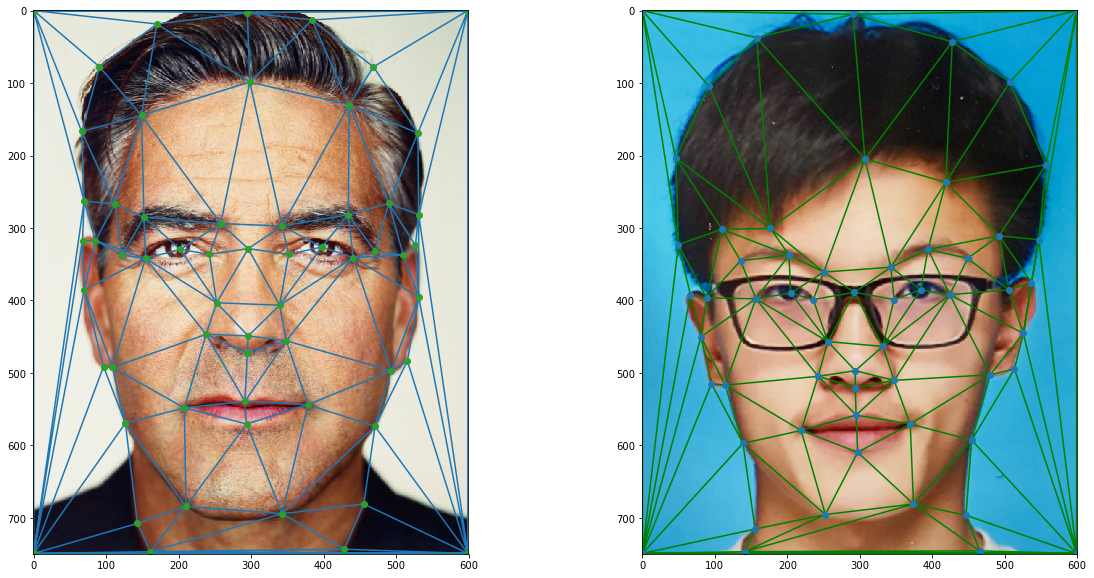

In [364]:
%matplotlib inline
tri = Delaunay((pts1+pts2)/2)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.triplot(pts1[:,0], pts1[:,1], tri.simplices)
plt.plot(pts1[:,0], pts1[:,1], 'o')

plt.subplot(1, 2, 2)
plt.imshow(im2)
plt.triplot(pts2[:,0], pts2[:,1], tri.simplices, color='g')
plt.plot(pts2[:,0], pts2[:,1], 'o')

plt.savefig('output/triangulation.jpg')

### Computing the "Mid-way Face"

In [17]:
def computeAffine(tri1_pts, tri2_pts):
    # points are in the same order shape(3, 2)
    v1 = np.reshape((tri1_pts[1] - tri1_pts[0]), (2, 1))
    v2 = np.reshape((tri1_pts[2] - tri1_pts[0]), (2, 1))
    mat1 = np.hstack([v1, v2, np.resize(tri1_pts[0], (2, 1))])
    mat1 = np.vstack([mat1, np.array([[0, 0, 1]])])
    mat1 = np.linalg.inv(mat1)
    u1 = np.reshape(tri2_pts[1] - tri2_pts[0], (2, 1))
    u2 = np.reshape(tri2_pts[2] - tri2_pts[0], (2, 1))
    mat2 = np.hstack([u1, u2, np.resize(tri2_pts[0], (2, 1))])
    mat2 = np.vstack([mat2, np.array([[0, 0, 1]])])
    mat_T = np.dot(mat2, mat1)
    return mat_T

In [18]:
# mid-way face
mid_pts = (pts1 + pts2) / 2
mask1 = np.zeros((im_shape[0], im_shape[1], 3))
mask2 = np.zeros((im_shape[0], im_shape[1], 3))
for tri_index in tri.simplices:
    src1_tri = pts1[tri_index]
    src2_tri = pts2[tri_index]
    mid_tri = mid_pts[tri_index]
    
    mat_T1 = computeAffine(src1_tri, mid_tri)
    mat_T2 = computeAffine(src2_tri, mid_tri)
    
    rr, cc = polygon(mid_tri[:, 0], mid_tri[:, 1])
    mid_xys = np.array([rr, cc])
    
    src1_xys = np.dot(np.linalg.inv(mat_T1), np.vstack([mid_xys, np.ones((1, mid_xys.shape[1]))])).astype(int)
    src2_xys = np.dot(np.linalg.inv(mat_T2), np.vstack([mid_xys, np.ones((1, mid_xys.shape[1]))])).astype(int)
    # todo use interpolation
    mask1[mid_xys[1], mid_xys[0]] = im1[src1_xys[1], src1_xys[0]]
    mask2[mid_xys[1], mid_xys[0]] = im2[src2_xys[1], src2_xys[0]]

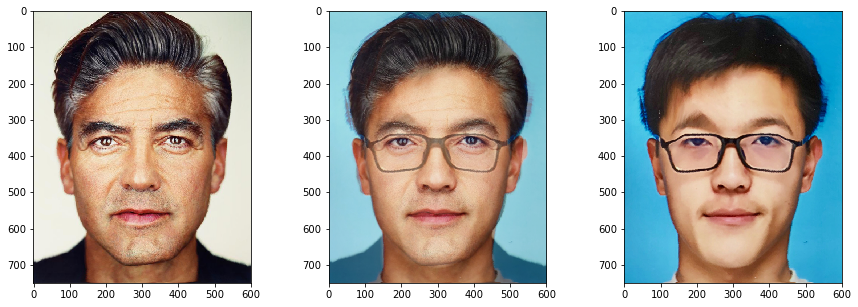

In [360]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(mask1)
plt.subplot(1, 3, 2)
mid_img = (mask1+mask2)/2
plt.imshow(mid_img)
plt.subplot(1, 3, 3)
plt.imshow(mask2)
plt.savefig('output/midway_face.jpg')

### The Morph Sequence

In [20]:
def morph(im1, im2, pts1, pts2, tri, warp_frac, dissolve_frac):
    assert 0<=warp_frac<=1 and 0<=dissolve_frac<=1
    assert im1.shape == im2.shape
    mid_pts = warp_frac*pts1 + (1-warp_frac)*pts2
    mask1 = np.zeros((im1.shape[0], im1.shape[1], 3))
    mask2 = np.zeros((im2.shape[0], im2.shape[1], 3))
    for tri_index in tri.simplices:
        src1_tri = pts1[tri_index]
        src2_tri = pts2[tri_index]
        mid_tri = mid_pts[tri_index]
        
        # todo swap order so as not to compuute inverse
        mat_T1 = computeAffine(src1_tri, mid_tri)
        mat_T2 = computeAffine(src2_tri, mid_tri)

        rr, cc = polygon(mid_tri[:, 0], mid_tri[:, 1])
        mid_xys = np.array([rr, cc])

        src1_xys = np.dot(np.linalg.inv(mat_T1), np.vstack([mid_xys, np.ones((1, mid_xys.shape[1]))])).astype(int)
        src2_xys = np.dot(np.linalg.inv(mat_T2), np.vstack([mid_xys, np.ones((1, mid_xys.shape[1]))])).astype(int)
        # todo use interpolation
        mask1[mid_xys[1], mid_xys[0]] = im1[src1_xys[1], src1_xys[0]]
        mask2[mid_xys[1], mid_xys[0]] = im2[src2_xys[1], src2_xys[0]]
        morphed_im = dissolve_frac*mask1 + (1-dissolve_frac)*mask2
    return morphed_im

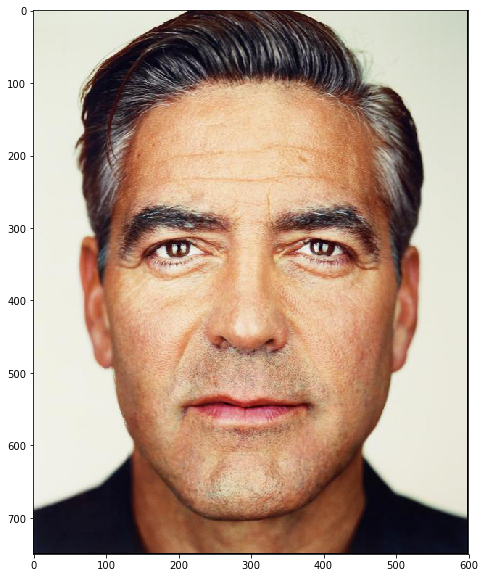

In [23]:
fig = plt.figure(figsize=(8, 10))

ims = []
total_frames = 45
for frac in np.linspace(0, 1, total_frames):
    morphed_im = morph(im1, im2, pts1, pts2, tri, frac, frac)
    im = plt.imshow(morphed_im, animated=True)
    ims.append([im])


In [25]:
# animate & save
anim = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                 repeat_delay=1000)
anim.save('morph_slow.gif', writer='imagemagick', fps=10)
anim.save('morph.gif', writer='imagemagick', fps=30)

### The "Mean face" of a population

In [161]:
def get_pts_from_asf(path2file, is_add_corners=True):
    with open(path2file, 'r') as f:
        data = f.readlines()[16:74]
    pts_rel = np.array([data[i].split('\t')[2:4] for i in range(len(data))]).astype(float)
    im = plt.imread('data/imm_face_db/01-1m.jpg')
    pts_real = np.multiply(np.array([im.shape[1], im.shape[0]]), pts_rel)
    if is_add_corners:
        pts_real = np.vstack([pts_real, np.array([[0, 0], [im.shape[1]-1, 0], [0, im.shape[0]-1], [im.shape[1]-1, im.shape[0]-1]])])
    return pts_real

In [368]:
def mean_face(ims, pts):
    num_ims = len(ims)
    mask = np.zeros((ims[0].shape[0], ims[0].shape[1], 3))
#     print('im_shape', mask.shape)
    mean_pts = np.mean(pts, axis=0)
    tri = Delaunay(mean_pts)
    for tri_index in tri.simplices:
        src_tris = [pts[i][tri_index] for i in range(num_ims)]
        mid_tri = mean_pts[tri_index]
        mat_Ts = [computeAffine(src_tris[i], mid_tri) for i in range(num_ims)]
        
        rr, cc = polygon(mid_tri[:, 0], mid_tri[:, 1])
        mid_xys = np.array([rr, cc])
        
        src_xys = [np.dot(np.linalg.inv(mat_Ts[i]), np.vstack([mid_xys, np.ones((1, mid_xys.shape[1]))])).astype(int) 
                   for i in range(num_ims)]
        
        for i in range(num_ims):
#             print('mid_xys shape', mid_xys.shape)
            mask[mid_xys[1], mid_xys[0]] += ims[i][src_xys[i][1], src_xys[i][0]]/num_ims
    return mask

In [334]:
from os import listdir
dir_db = 'data/imm_face_db/'
# nm stands for neutral males
ims_nm = []
pts_nm = []
for file in listdir(dir_db):
    if '1m' in file.split('.')[0] and file.split('.')[1] == 'jpg':
        ims_nm.append(plt.imread(dir_db+file)/255)
        pts_nm.append(get_pts_from_asf(dir_db+file.split('.')[0]+'.asf'))
mean_face_nm = mean_face(ims_nm, pts_nm)


In [335]:
# hm stands for happy males
ims_hm = []
pts_hm = []
for file in listdir(dir_db):
    if '2m' in file.split('.')[0] and file.split('.')[1] == 'jpg':
        ims_hm.append(plt.imread(dir_db+file)/255)
        pts_hm.append(get_pts_from_asf(dir_db+file.split('.')[0]+'.asf'))
mean_face_hm = mean_face(ims_hm, pts_hm)

In [336]:
# nf stands for neutral females
ims_nf = []
pts_nf = []
for file in listdir(dir_db):
    if '1f' in file.split('.')[0] and file.split('.')[1] == 'jpg':
        ims_nf.append(plt.imread(dir_db+file)/255)
        pts_nf.append(get_pts_from_asf(dir_db+file.split('.')[0]+'.asf'))
mean_face_nf = mean_face(ims_nf, pts_nf)

In [337]:
# hf stands for happy females
ims_hf = []
pts_hf = []
for file in listdir(dir_db):
    if '2f' in file.split('.')[0] and file.split('.')[1] == 'jpg':
        ims_hf.append(plt.imread(dir_db+file)/255)
        pts_hf.append(get_pts_from_asf(dir_db+file.split('.')[0]+'.asf'))
mean_face_hf = mean_face(ims_hf, pts_hf)

In [367]:
# compute mean points
mean_pts_nm = np.mean(pts_nm, axis=0)
mean_pts_hm = np.mean(pts_hm, axis=0)
mean_pts_nf = np.mean(pts_nm, axis=0)
mean_pts_hf = np.mean(pts_hf, axis=0)

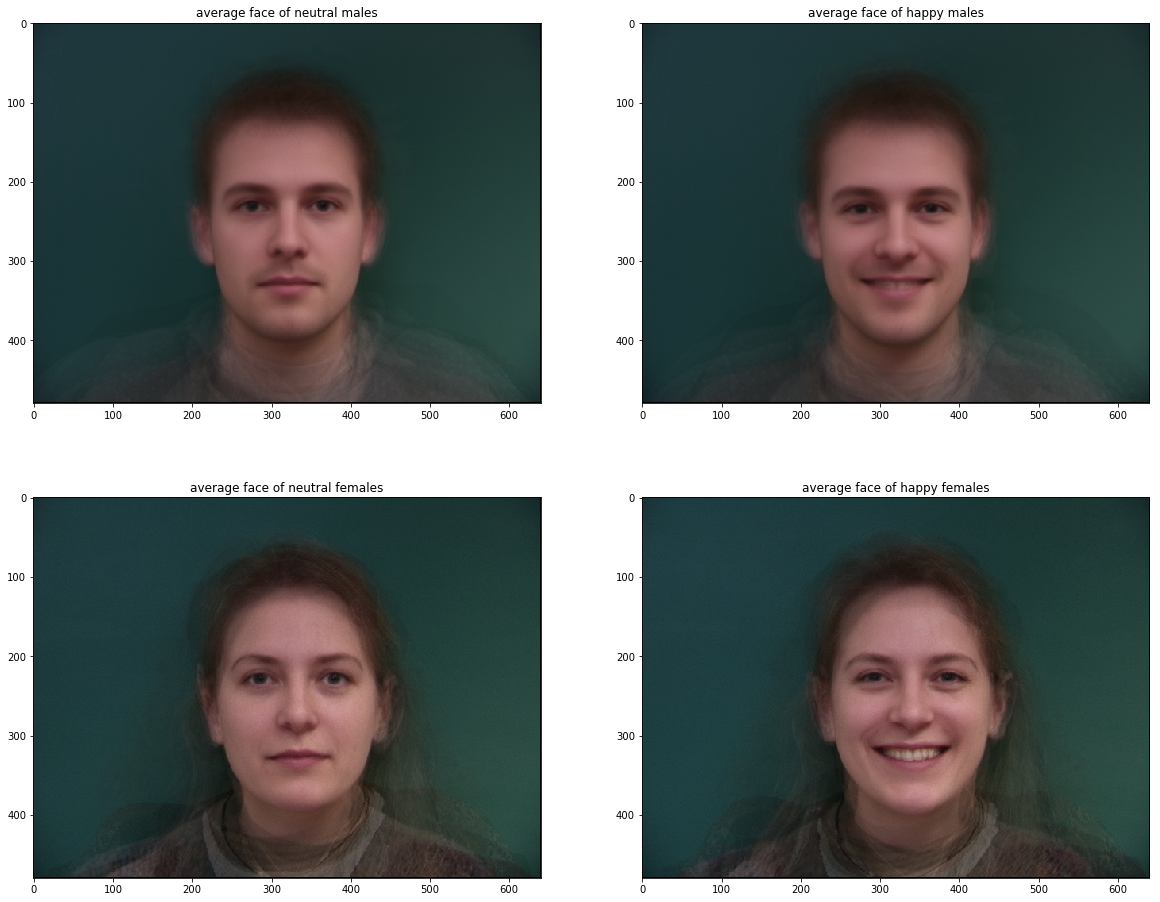

In [361]:
plt.figure(figsize=(20, 16))
plt.subplot(2, 2, 1)
plt.imshow(mean_face_nm)
plt.title('average face of neutral males')
plt.subplot(2, 2, 2)
plt.imshow(mean_face_hm)
plt.title('average face of happy males')
plt.subplot(2, 2, 3)
plt.imshow(mean_face_nf)
plt.title('average face of neutral females')
plt.subplot(2, 2, 4)
plt.imshow(mean_face_hf)
plt.title('average face of happy females')

plt.savefig('output/mean_face.jpg')

In [365]:
def warp(src, pts_src, pts_tgt, alpha=1):
    #assert src.shape == tgt.shape
    assert pts_src.shape == pts_tgt.shape
    pts_tgt = alpha*pts_tgt + (1-alpha)*pts_src
    mean_pts = (pts_src+pts_tgt)/2
    tri = Delaunay(mean_pts)
    mask = np.zeros((src.shape[0], src.shape[1], 3))
    for tri_index in tri.simplices:
        src_tri = pts_src[tri_index]
        tgt_tri = pts_tgt[tri_index]
        
        mat_T = computeAffine(src_tri, tgt_tri)
        
        rr, cc = polygon(tgt_tri[:, 0], tgt_tri[:, 1])
        tgt_xys = np.array([rr, cc])
        src_xys = np.dot(np.linalg.inv(mat_T), np.vstack([tgt_xys, np.ones((1, tgt_xys.shape[1]))])).astype(int)
        mask[tgt_xys[1], tgt_xys[0]] = src[src_xys[1], src_xys[0]]        
    return mask

In [370]:
# warp some faces to mean faces
im_nm = warp(ims_nm[0], pts_nm[0], mean_pts_nm)
im_hm = warp(ims_hm[0], pts_hm[0], mean_pts_hm)
im_nf = warp(ims_nf[0], pts_nf[0], mean_pts_nf)
im_hf = warp(ims_hf[0], pts_hf[0], mean_pts_hf)

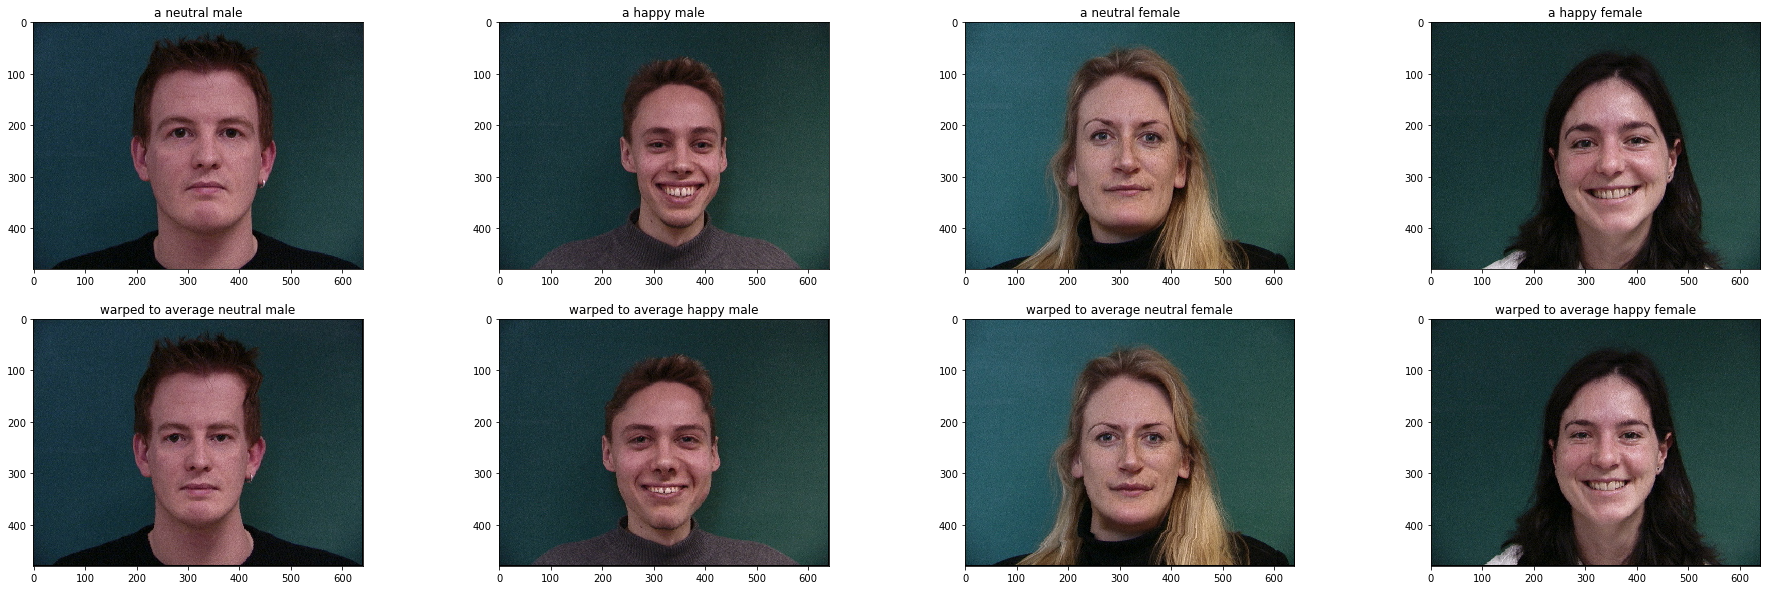

In [378]:
plt.figure(figsize=(32, 10))
plt.subplot(2, 4, 1)
plt.imshow(ims_nm[0])
plt.title('a neutral male')
plt.subplot(2, 4, 2)
plt.imshow(ims_hm[0])
plt.title('a happy male')
plt.subplot(2, 4, 3)
plt.imshow(ims_nf[0])
plt.title('a neutral female')
plt.subplot(2, 4, 4)
plt.imshow(ims_hf[0])
plt.title('a happy female')

plt.subplot(2, 4, 5)
plt.imshow(im_nm)
plt.title('warped to average neutral male')
plt.subplot(2, 4, 6)
plt.imshow(im_hm)
plt.title('warped to average happy male')
plt.subplot(2, 4, 7)
plt.imshow(im_nf)
plt.title('warped to average neutral female')
plt.subplot(2, 4, 8)
plt.imshow(im_hf)
plt.title('warped to average happy female')

plt.savefig('output/warp2mean.jpg')

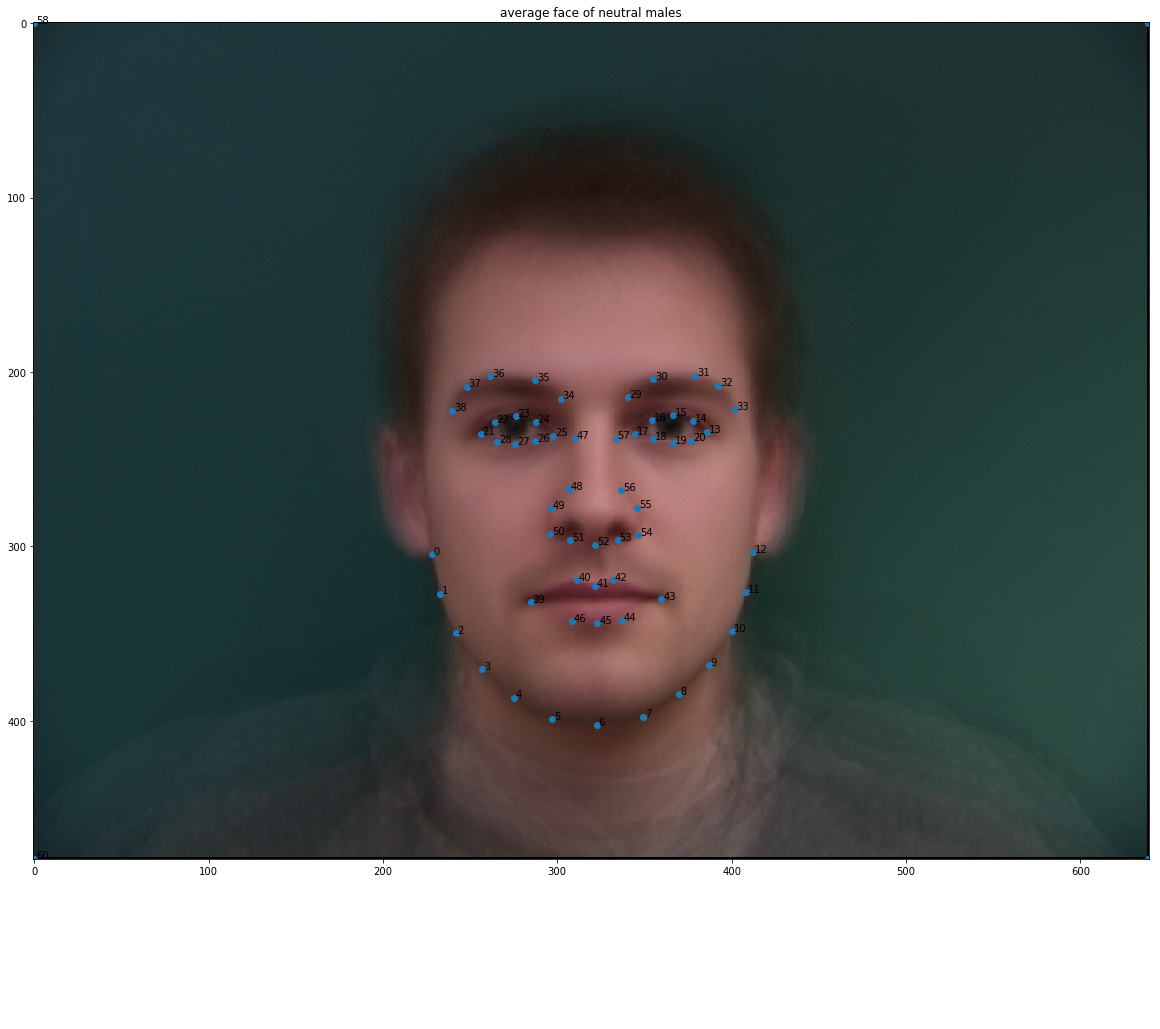

In [339]:
# get annotation sequence
plt.figure(figsize=(20, 16))
ax = plt.subplot(1, 1, 1)
plt.imshow(mean_face_nm)
plt.title('average face of neutral males')
mean_pts_nm = np.mean(pts_nm, axis=0)
plt.plot(mean_pts_nm[:, 0], mean_pts_nm[:, 1], 'o')
for i in range(mean_pts_nm.shape[0]):
    ax.annotate(str(i),xy=(mean_pts_nm[i, 0]+1, mean_pts_nm[i, 1]))

In [342]:
def crop(face, pts):
    face_crop = face[50:430, 168:472]
    pts_crop = pts - np.array([168, 50])
    pts_crop = np.vstack([pts_crop[:-4], 
                          np.array([[0, 0], [face_crop.shape[1]-1, 0], [0, face_crop.shape[0]-1], 
                                    [face_crop.shape[1]-1, face_crop.shape[0]-1]])])
    return face_crop, pts_crop


In [343]:
# crop the image
mean_face_nm_crop, mean_pts_nm_crop = crop(mean_face_nm, mean_pts_nm)
mean_face_hm_crop, mean_pts_hm_crop = crop(mean_face_hm, mean_pts_hm)
mean_face_nf_crop, mean_pts_nf_crop = crop(mean_face_nf, mean_pts_nf)
mean_face_hf_crop, mean_pts_hf_crop = crop(mean_face_hf, mean_pts_hf)

In [225]:
im_me = plt.imread('data/la.jpg')
im_me = sktr.resize(im_me, mean_face_nm_crop.shape)
%matplotlib qt
pts_me_orig = get_points(im_me, 58)

Please select {} points in each image for alignment. 58


#### my face warped into the average geometry

In [226]:
%matplotlib inline
pts_me = np.vstack([pts_me_orig, np.array([[0, 0], [im_me.shape[1]-1, 0], [0, im_me.shape[0]-1], 
                                           [im_me.shape[1]-1, im_me.shape[0]-1]])])

np.save('pts_la_orig_imm.npy', pts_me)

In [345]:
im_me2average_nm = warp(im_me, pts_me, mean_pts_nm_crop)
im_average_nm2me = warp(mean_face_nm_crop, mean_pts_nm_crop, pts_me)

im_me2average_hm = warp(im_me, pts_me, mean_pts_hm_crop)
im_average_hm2me = warp(mean_face_hm_crop, mean_pts_hm_crop, pts_me)

im_me2average_nf = warp(im_me, pts_me, mean_pts_nf_crop)
im_average_nf2me = warp(mean_face_nf_crop, mean_pts_nf_crop, pts_me)

im_me2average_hf = warp(im_me, pts_me, mean_pts_hf_crop)
im_average_hf2me = warp(mean_face_hf_crop, mean_pts_hf_crop, pts_me)

#### the average face warped into my geometry

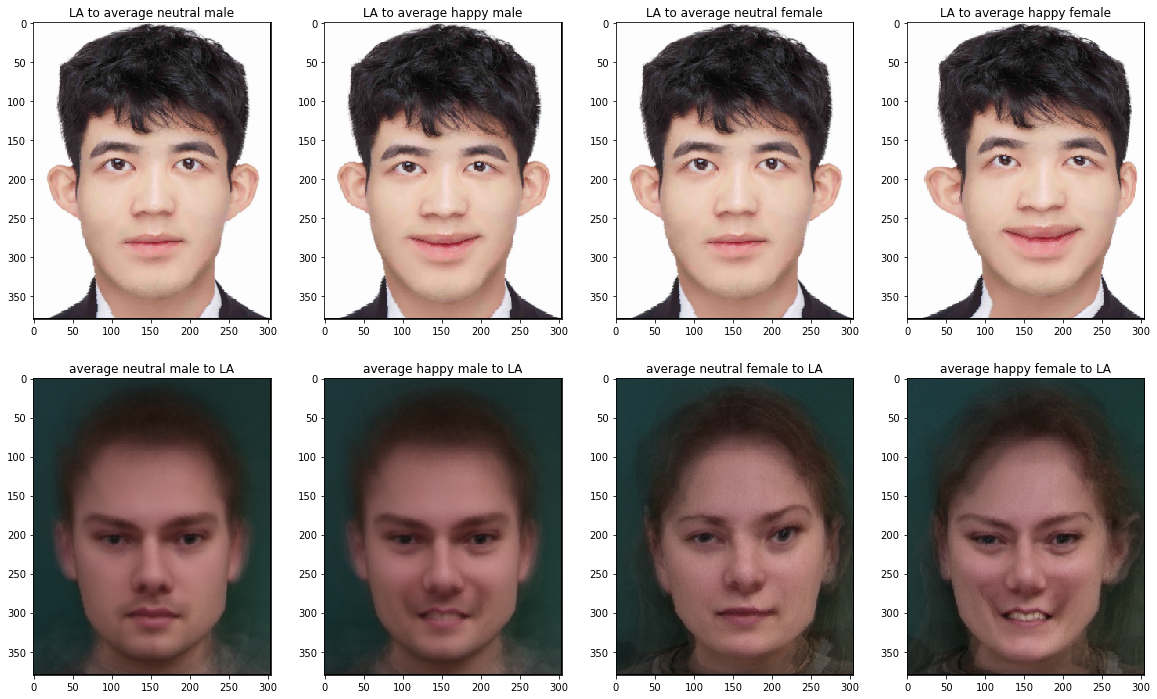

In [362]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 4, 1)
plt.imshow(im_me2average_nm)
plt.title('LA to average neutral male')
plt.subplot(2, 4, 2)
plt.imshow(im_me2average_hm)
plt.title('LA to average happy male')
plt.subplot(2, 4, 3)
plt.imshow(im_me2average_nf)
plt.title('LA to average neutral female')
plt.subplot(2, 4, 4)
plt.imshow(im_me2average_hf)
plt.title('LA to average happy female')
plt.subplot(2, 4, 5)
plt.imshow(im_average_nm2me)
plt.title('average neutral male to LA')
plt.subplot(2, 4, 6)
plt.imshow(im_average_hm2me)
plt.title('average happy male to LA')
plt.subplot(2, 4, 7)
plt.imshow(im_average_nf2me)
plt.title('average neutral female to LA')
plt.subplot(2, 4, 8)
plt.imshow(im_average_hf2me)
plt.title('average happy female to LA')

plt.savefig('output/warped_face.jpg')

### caricatures: Extrapolating from the mean

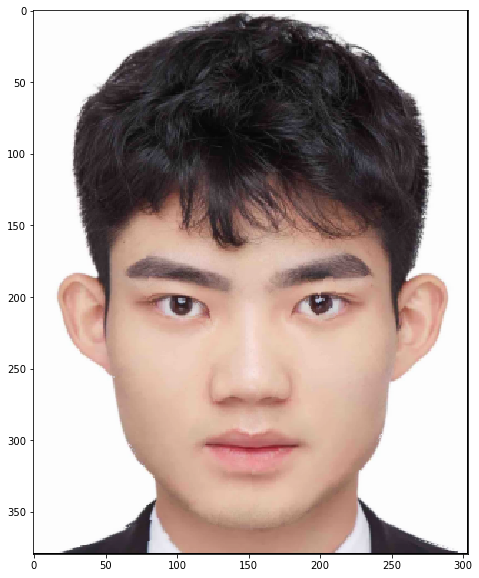

In [252]:
fig = plt.figure(figsize=(8, 10))

ims = []
total_frames = 45
for alpha in np.concatenate([np.linspace(0, 1.5, total_frames//2), np.linspace(1.5, 0, total_frames//2)]):
    morphed_im = warp(im_me, pts_me, mean_pts_hm_crop, alpha)
    im = plt.imshow(morphed_im, animated=True)
    ims.append([im])

In [253]:
anim = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                 repeat_delay=1000)
anim.save('caricature.gif', writer='imagemagick', fps=10)


### Bells & Whistles

In [347]:
im_male = plt.imread('data/imm_face_db/11-1m.jpg')/255
pts_male = get_pts_from_asf('data/imm_face_db/11-1m.asf')
im_male, pts_male = crop(im_male, pts_male)

In [348]:
pts_female = pts_male + (mean_pts_nf_crop - mean_pts_nm_crop)
im_change_shape = warp(im_male, pts_male, pts_female)

mean_face_nm2male = warp(mean_face_nm_crop, mean_pts_nm_crop, pts_male)
mean_face_nf2male = warp(mean_face_nf_crop, mean_pts_nf_crop, pts_male)
color_diff = mean_face_nf2male - mean_face_nm2male
im_change_color = im_male + color_diff
im_change_shape_color = np.clip(im_change_shape + color_diff, 0, 1)
# im_change_shape_color = im_change_shape + color_diff

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


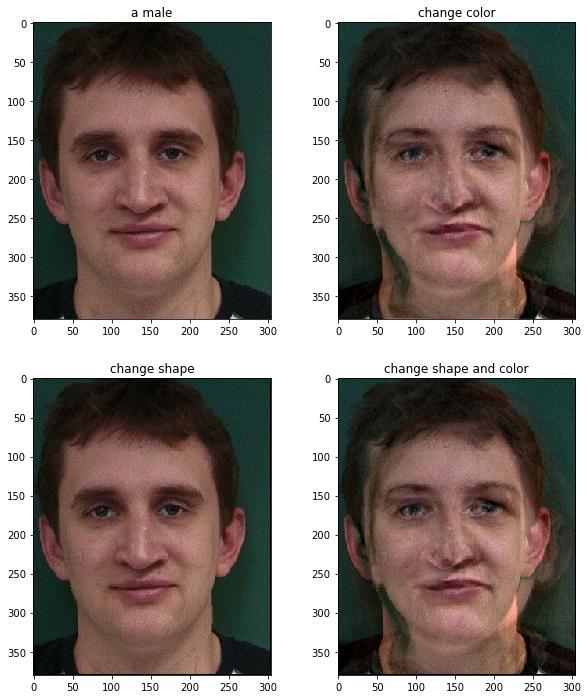

In [363]:
plt.figure(figsize=(10, 12))
plt.subplot(2, 2, 1)
plt.imshow(im_male)
plt.title('a male')
plt.subplot(2, 2, 2)
plt.imshow(im_change_color)
plt.title('change color')
plt.subplot(2, 2, 3)
plt.imshow(im_change_shape)
plt.title('change shape')
plt.subplot(2, 2, 4)
plt.imshow(im_change_shape_color)
plt.title('change shape and color')

plt.savefig('output/change_gender.jpg')

total ims:  30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


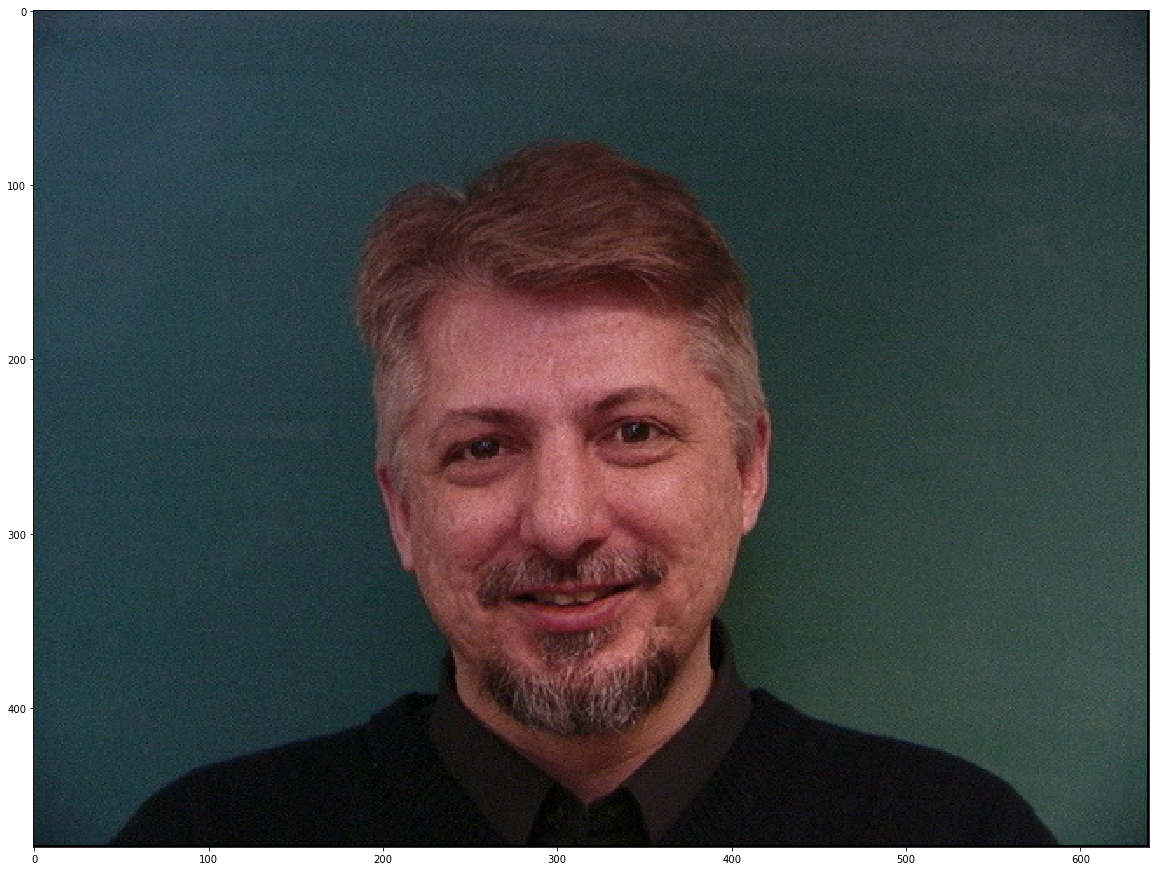

In [357]:
mean_pts = np.mean(pts_hm, axis=0)
tri = Delaunay(mean_pts)

fig = plt.figure(figsize=(20, 16))
ims = []
total_frames = 30
print('total ims: ', len(ims_hm))
for i in range(len(ims_hm)-1):
    print(i)
#     print(ims_hm[i], ims_hm[i+1])
    for frac in np.linspace(0, 1, total_frames):
        morphed_im = morph(ims_hm[i+1], ims_hm[i], pts_hm[i+1], pts_hm[i], tri, frac, frac)
        im = plt.imshow(morphed_im, animated=True)
        ims.append([im])

In [358]:
anim = animation.ArtistAnimation(fig, ims, interval=30, blit=True)
anim.save('mv.mp4')